In [1]:
%matplotlib inline

In [2]:
import time
debut = time.time()

# DCGAN Tutorial

This tutorial aims to see how a generative opposition network (GAN) can generate new faces after seeing many photos of real faces.

It is very, very strongly inspired by the pytorch tutorial : [dcgan_faces_tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

## Generative Adversarial Networks

### What is a GAN?

GANs are a teaching model of a DL model to capture the distribution of training data in order to generate new data from the same distribution. GANs were invented by Ian Goodfellow in 2014 and first described in [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf). They are made up of two distinct models, a **generator** and a **discriminator**:

- The generator produces false images that look like training images.
- The discriminator looks at an image and displays whether or not it is a real training image or a false image from the generator.

During training, the generator constantly tries to outperform the discriminator by generating better fakes, while the discriminator strives to become a better detective and correctly classify real and false images. The balance of this game is when the generator generates perfect fakes that seem to come directly from the training data, and the discriminator must always guess at 50% that the generator output is real or false.

<img src="https://www.kdnuggets.com/wp-content/uploads/generative-adversarial-network.png" width="900"/>


Some notes :

- For the discriminator:
    - **$x$** : data representing an image.
    - **$D(x)$ : the network of discriminators** that provides the (scalar) probability that $x$ comes from the training data rather than the generator. The entry at $D(x)$ is an RGB image of size 3x64x64. $D(x)$ should be HIGH when $x$ comes from real data and LOW when $x$ comes from the generator. $D(x)$ can also be considered as a binary classifier.

- For the generator:
    - **$z$** : a latent space vector sampled from a standard normal distribution.
    - **$G(z)$ : the generator function** that maps the latent vector $z$ to the data space. The objective of $G$ is to estimate the distribution from which the training data originates ($p_{data}$) in order to generate false samples from this estimated distribution ($p_g$).

**$D(G(z))$ is the (scalar) probability that the output of the $G$ generator is a real image**.

As described in [Goodfellow's article](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), $D$ and $G$ play a minimax game :
- **$D$** tries to **maximize** the probability that it correctly classifies the real and false ($logD(x)$)
- **$G$** tries to **minimize** the probability that $D$ will predict that its results will be false ($log(1-D(G(x))$)). 

From the paper, the GAN loss function is as follows:

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}

In theory, **the solution to this minimax set is where $p_g = p_{data}$**, and the discriminator randomly guesses whether the entries are real or false.

However, GAN convergence theory is still under active research and, in reality, models do not always practice to this extent.

### What is a DCGAN?

A DCGAN is a direct extension of GAN, except that it explicitly uses convolutional and convolutional-transpositive layers in the discriminator and generator, respectively. It was first described by Radford et al. in [Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf).

- The discriminator is composed of strided [convolution](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) layers, [BatchNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) layers and activation layers [LeakyReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU). The input is a 3x64x64 input image and the output is a scalar probability that the input comes from the actual distribution of the data.

- The generator is composed of [convolutional-transpose](https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d) layers,[BatchNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) layers and [ReLU](https://pytorch.org/docs/stable/nn.html#relu) activations. The input is a latent vector, $z$, which is derived from a standard normal distribution and the output is a 3x64x64 RGB image. The conv-transposed strided layers transform the latent vector into a volume having the same shape as an image.

In this article, the authors also give some advice on how to configure optimizers, calculate loss functions and initialize model weights.

In [3]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt


# Set random seed for reproducibility
import random
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Inputs

Let's define some entries for the run :

In [4]:
dataroot = 'images/CFD_Images' # Root directory for the data set

batch_size = 3**2  # Lot size during training
image_size = 64 # Spatial size of training images.
                #     All images will be resized as follows using a transformer.
                #     This default implementation is 64x64.
                #     If another size is desired, the structures of D and L must be modified.
                #     See [here](https://github.com/pytorch/examples/issues/70)

nc = 3   # Number of channels in the training images. (3 for color images)
nz = 100 # Latent vector size z (i.e. generator input size)
ngf = 64 # Size of entity cards in the generator
ndf = 64 # Size of entity cards in the discriminator

num_epochs = 15  # Number of training periods to be performed.
                 # A longer training period will probably lead to better results,
                 # but will also take much longer


ngpu = 1        # Number of GPUs available. Use 0 for CPU mode.

## Data

In this tutorial, we will use the [Chicago Face Database](https://chicagofaces.org/default/) dataset. The *CFD_Images* folder should be placed in the *images* folder:

    /images/CFD_Images
       AF-200 -> AF-200
           -> CFD-AF-200-228-N.jpg
       FY-201 -> FY-201
           -> CFD-AF-201-060-N.jpg
          ...

ImageFolder will be used to create the data set, it requires that there are subdirectories in the root folder (these subdirectories are used to create the data classes, which we will not use here).

In [5]:
# We can use an image folder data set the way we configured it.

# Transformation to be done on the training image
import torchvision.transforms as transforms
transform=transforms.Compose([transforms.Resize(image_size), # Resize the input PIL Image to the given size.
                              transforms.CenterCrop(image_size), # Crops the given PIL Image at the center.
                              transforms.ToTensor(), # Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
                              transforms.Normalize(mean=(0.5, 0.5, 0.5), # Normalize a tensor image with mean and standard deviation.
                                                   std=(0.5, 0.5, 0.5)) 
                             ]) 



# Create the data set
import torchvision.datasets as dset
dataset = dset.ImageFolder(root=dataroot, transform=transform)

# Create the dataloader -- allows you to use the dataset with torch
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Decide on which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
#device = torch.device("cpu")
device

device(type='cuda', index=0)

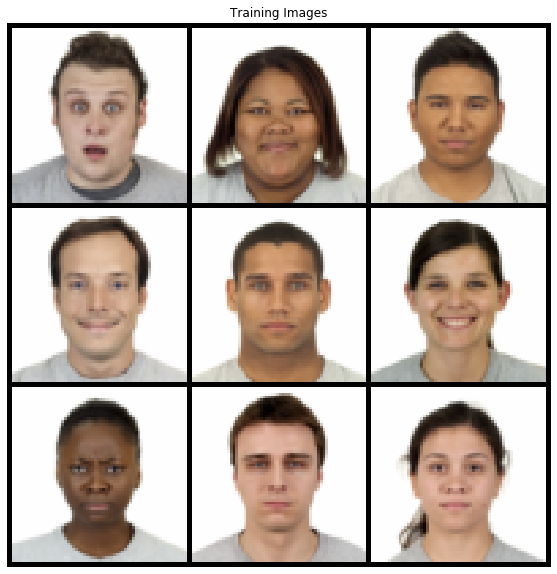

In [6]:
# Display training images

real_batch = next(iter(dataloader))
# real_batch[0] -> images of a training batch
# real_batch[1] -> classes of images of a training batch


import torchvision.utils as vutils
# we make a grid of images
grid_images = vutils.make_grid(real_batch[0].to(device), padding=2, nrow=int(batch_size**.5), normalize=True).cpu()
images = np.transpose(grid_images, (1,2,0)) # allows you to rearrange grid_images to display it


plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(images);

## Implementation

### Weight initialization


According to the DCGAN article, the authors specify that all **the weights of the model must be randomly initialized** from a **normal distribution (mean=0 and stdev=0.02)**.

The ``weights_init`` function takes an initialized model as input and resets all layers of convolutional, convolutional-transposition and batch normalization to meet this criterion. This function is applied to the models immediately after initialization.

In [7]:
# Function to initialize customized weights called on the generator and discriminator networks
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

The generator, $G$, is designed to map the latent space vector ($z$) into the data space.

Since our data is images, converting $z$ to data space means creating an RGB image of the same size as the training images (here 3x64x64). This is done by a series of transposed two-dimensional convolutional layers (**ConvTranspose2d**), each coupled to a layer of **BatchNorm2d** and an activation **ReLu**. The generator output is powered by a **Tanh** function to return to the input data range of $[-1.1]$. The functions of BatchNorm2d are located after the ConvTranspose2d layers, it is an essential contribution of the DCGAN document. These layers help the flow of gradients during training.

An image of the generator from the DCGAN article is shown below.

<img src="https://pytorch.org/tutorials/_images/dcgan_generator.png" width="900"/>

The inputs defined in the input section (*nz*, *ngf*, and *nc*) influence the architecture of the generator :
- **nz** is the length of the input vector z,
- **ngf** refers to the size of the characteristic maps that are propagated by the generator,
- **nc** is the number of channels in the output image (set to 3 for RGB images).

In [8]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # entry is Z, entering a convolution
            nn.ConvTranspose2d(nz, ngf*8, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # state size (ngf*8) x 4 x 4 x 4
            
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size (ngf*4) x 8 x 8 x 8
            
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # state size (ngf*2) x 16 x 16 x 16
            
            nn.ConvTranspose2d(ngf*2, ngf, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size (ngf) x 32 x 32 x 32
            
            nn.ConvTranspose2d(ngf, nc, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size (nc) x 64 x 64 x 64
        
        )

    def forward(self, input):
        return self.main(input)

### Discriminator

The $D$ discriminator is a binary classification network that takes an input image and emits a scalar probability that the input image is real (as opposed to false).

Here, $D$ takes an input image 3x64x64, processes it through a series of layers **Conv2d**, **BatchNorm2d**, and **LeakyReLU**, and displays the final probability by a Sigmoid activation function.

This architecture can be extended with other layers, but the use of stride convolution (here stride = 2 or 1), BatchNorm and LeakyReLU is important. The DCGAN document mentions that it is good practice to use striated convolution rather than pooling to reduce the sample because it allows the network to learn its own pooling function. In addition, the BatchNorm and LeakyReLU functions promote a balanced gradient flow, which is essential for the $G$ and $D$ learning process.

<img src="https://sigmoidal.io/wp-content/uploads/2017/09/deep_convolutional_generative_adversarial_network1.png" width="1000"/>


In [9]:
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # Input is (nc) x 64 x 64 x 64
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf) x 32 x 32 x 32
            
            nn.Conv2d(ndf, ndf*2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*2) x 16 x 16 x 16
            
            nn.Conv2d(ndf*2, ndf*4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*4) x 8 x 8 x 8
            
            nn.Conv2d(ndf*4, ndf*8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*8) x 4 x 4 x 4
            
            nn.Conv2d(ndf*8, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now we can instantiate the generator and discriminator and apply the ``weights_init`` function. Check the returned model to see how the generator and discriminator objects are structured.

In [10]:
# Create the generator
netG = Generator(ngpu).to(device)

# Create the discriminator
netD = Discriminator(ngpu).to(device)


# Handle the multi-gpu if you wish
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights for mean=0, stdev=0.2.
netG.apply(weights_init)
netD.apply(weights_init)

# Show models
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Loss functions and optimizers

With the $D$ and $G$ configuration, we can specify how they learn through loss functions and optimizers.

- The binary entropy loss function [BCELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss) will be used. It is defined in PyTorch as :
    \begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}
    This function provides the calculation of the two log components in the objective function ($log(D(x))$ and $log(1-D(G(z)))$).
    
    The part of the BCE equation to be used can be specified by simply changing $y$ (the labels):
    - $l_n = -[\log x_n]$ for $y=1$
    - $l_n = - [\log (1 - x_n)]$ for $y=0$

- The actual label will be defined as 1 and the false label as 0 and will be used to calculate the losses of $D$ and $G$.

- Two separate optimizers will be implemented, one for $D$ and the other for $G$. Both are Adam optimizers with a learning rate (lr) of 0.0002 and Beta1 = 0.5 (see DCGAN document).

To follow the learning progress of the generator, we will generate a fixed batch of latent vectors that are derived from a Gaussian distribution (fixed_noise). In the learning loop, we will periodically enter this fixed_noise into $G$, and during iterations, we will see images formed from the noise.

In [11]:
# Initialize the BCELoss function
criterion = nn.BCELoss()

# Create a batch of latent vectors that we will use to visualize the progress of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish a convention for real and fake labels during training
real_label = 1
fake_label = 0

# Configure Adam optimizers for G and D
import torch.optim as optim

lr = 0.0002     # Optimizer learning rate
beta1 = 0.5     # Beta1 hyperparameter for Adam optimizers

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training


GAN training is tricky, incorrect hyperparametric parameters cause the mode to collapse without really knowing what went wrong.

Here, we will follow algorithm 1 of Goodfellow's article, while respecting some of the best practices presented in [ganhacks](https://github.com/soumith/ganhacks). Namely, we will "build different mini-lots for real and false images", and also adjust the objective function of G to maximize $log(D(G(z)))$.

The training is divided into two main parts. Part 1 updates the Discriminator and Part 2 updates the Generator.

- **Part 1 - Discriminator Training**

    The objective of this training is to maximize the probability of correctly classifying a given input as real or false. As far as Goodfellow is concerned, we want to "update the discriminator by increasing its stochastic gradient". In concrete terms, we want to **maximize $log(D(x)) + log(1-D(G(z)))$**. Due to the suggestion of separate mini-lots of ganhacks, we will calculate this in two steps:
    1. Training with batches of **real images**:
        1. Build a batch of real samples
        2. Go through $D$
        3. Calculate the loss ($log(D(x))$)
        4. Calculate the gradients in a backward pass.
    2. Training with batches of **fake images**:
        1. Build a batch of false samples with the current generator
        2. Pass this lot by $D$
        3. Calculate the loss ($log(1-D(G(z)))$)
        4. *Accumulate* the gradients with a back pass.
    3. Update of the D parameters with an optimization step.

Now, with the gradients accumulated from the all real and all false batches, we call a step of the Discriminator optimizer.

- Part 2 - Generator Drive

    We want to train the Generator by **minimizing $log(1-D(G(z)))$** to generate better forgeries. Goodfellow showed that this did not allow sufficient gradients to be obtained, especially at the beginning of the learning process. As a corrective measure, we would rather **maximize $log(D(G(z)))$**.

    To classify the output of the Generator from Part 1 with the Discriminator, we will go through several steps:
    1. Calculates the loss of G using **real labels** ($log(D(G(z)))$)
    2. Calculates gradients of G in a backward pass
    3. Update of G parameters with an optimization step.

    Actual labels are used for the loss function, to use the $log(x)$ portion of the BCELoss (rather than the $log(1-x)$ portion)

At the end of each era, we will push our batch of fixed noise (fixed_noise) through the generator to visually follow the progress of the G formation.

The reported training statistics are:

- **Loss_D** - loss of discriminator $log(D(x)) + log(1-D(G(z)))$ - sum of losses for all actual and fake batches.
- **Loss_G** - loss of the generator $log(D(G(z)))$.
- **D(x)** - average output of the discriminator for the actual batch. It should start at about 1 and converge to 0.5 as G improves.
- **D(G(z))** - average output of the discriminator for the false batch. The first digit is before D is updated and the second digit is after D is updated. They should start near 0 and then converge to 0.5 as G improves.

**Note :** This step may take some time, depending on the number of times you run.

In [12]:
# Training loop

# Lists to monitor the progress of projects
img_list = []
G_losses = []
D_losses = []

D_x_score = []
D_G_z1_score = []
D_G_z2_score = []

iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs): # For each era
    
    for i, data in enumerate(dataloader, 0): # For each batch in the dataloader
        
        #====================================================================================================
        
        ###############################################################
        # 1 - Network D update : maximize log(D(x)) + log(1 - D(G(z)) #
        ###############################################################
        
        netD.zero_grad() # Sets the gradients of all model parameters to zero. (Backpropagation 1)
        
        #-----------------------------------------------------------------------
        
        # Training with batches of real images
        #------------------------------------------
        real_img = data[0].to(device) # x - Batch of real images
        b_size = real_img.size(0) # number of images in the batch
        
        label = torch.full((b_size,), real_label, device=device) # real_label for each image of the real batch
        output = netD(real_img).view(-1) # D(x) - Classifies the actual batch with D
        errD_real = criterion(output, label) # log(D(x)) - calculates the loss of D on the actual batch
        errD_real.backward()  # Calculates the gradients for D in steps backwards. (Backpropagation 2)
        D_x = output.mean().item()
        
        # Training with batches of false images
        #--------------------------------------------
        noise = torch.randn(b_size, nz, 1, 1, device=device) # z - Set of latent vectors
        fake = netG(noise) # G(z) - Creates a batch of false images with G
        
        label.fill_(fake_label) # fake_label for each image of the fake batch
        output = netD(fake.detach()).view(-1) # D(G(z)) - Classifies the wrong batch with D
        errD_fake = criterion(output, label) # log(1-D(G(z))) - calculates the loss of D on the false batch
        errD_fake.backward() # Calculates the gradients for D in steps backwards. (Backpropagation 2)
        D_G_z1 = output.mean().item()
        
        #-----------------------------------------------------------------------
        
        errD = errD_real + errD_fake # log(D(x)) + log(1-D(G(z)) - sum of the gradients of the real and false batches.
        optimizerD.step() # Update D (Backpropagation 3)
        
        ###############################################################
        # 2 - Updating the G network: maximize log(D(G(z)))           #
        ###############################################################
        
        netG.zero_grad() # Sets the gradients of all model parameters to zero. (Backpropagation 1)
        
        #-----------------------------------------------------------------------
        
        # Training with real labels  
        #-----------------------------------
        label.fill_(real_label) # real_label for each image of the false batch (for log(D(G(z)))
        output = netD(fake).view(-1) # D(G(z)) - Classifies the wrong batch with D (with D already updated)
        errG = criterion(output, label) # log(D(D(G(z))) - calculates the loss of G from this result.
        errG.backward() # Calculates the gradients for G in steps backwards. (Backpropagation 2)
        D_G_z2 = output.mean().item()
        
        #-----------------------------------------------------------------------
        
        optimizerG.step() # Update G (Backpropagation 3)
        
        #====================================================================================================
        
        
        # Training statistics
        if i % (len(dataloader)-1) == 0:
            print('[%d/%d][%d/%d]    \tLoss_D: %.3f\tLoss_G: %.3f\t\tD(x): %.3f\tD(G(z)): %.3f / %.3f'
                  % (epoch+1, num_epochs, i+1, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Recording:
        # - losses
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # - scores
        D_x_score.append(D_x)
        D_G_z1_score.append(D_G_z1)
        D_G_z2_score.append(D_G_z2)
        
        
        # Backup of G's output on fixed_noise.
        if (iters % len(dataloader) == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, nrow=int(batch_size**.5), normalize=True))
            
        iters += 1

Starting Training Loop...
[1/15][1/135]    	Loss_D: 1.502	Loss_G: 8.173		D(x): 0.667	D(G(z)): 0.571 / 0.001
[1/15][135/135]    	Loss_D: 0.000	Loss_G: 37.079		D(x): 1.000	D(G(z)): 0.000 / 0.000
[2/15][1/135]    	Loss_D: 0.000	Loss_G: 35.556		D(x): 1.000	D(G(z)): 0.000 / 0.000
[2/15][135/135]    	Loss_D: 0.024	Loss_G: 9.763		D(x): 1.000	D(G(z)): 0.024 / 0.000
[3/15][1/135]    	Loss_D: 3.877	Loss_G: 32.832		D(x): 0.993	D(G(z)): 0.624 / 0.000
[3/15][135/135]    	Loss_D: 0.030	Loss_G: 6.328		D(x): 0.999	D(G(z)): 0.029 / 0.002
[4/15][1/135]    	Loss_D: 0.227	Loss_G: 3.945		D(x): 0.844	D(G(z)): 0.020 / 0.057
[4/15][135/135]    	Loss_D: 0.123	Loss_G: 3.235		D(x): 0.970	D(G(z)): 0.088 / 0.039
[5/15][1/135]    	Loss_D: 4.268	Loss_G: 10.506		D(x): 1.000	D(G(z)): 0.972 / 0.000
[5/15][135/135]    	Loss_D: 0.045	Loss_G: 5.894		D(x): 0.989	D(G(z)): 0.034 / 0.003
[6/15][1/135]    	Loss_D: 0.199	Loss_G: 5.521		D(x): 0.972	D(G(z)): 0.143 / 0.006
[6/15][135/135]    	Loss_D: 0.641	Loss_G: 0.259		D(x): 0.5

## Results

### Loss versus training iteration

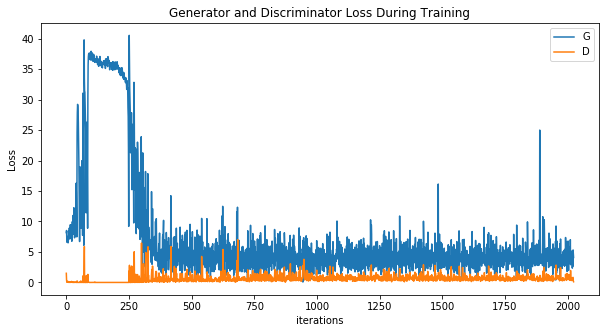

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Score versus training iteration

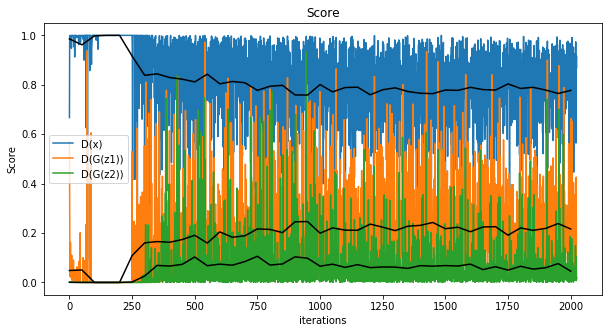

In [14]:
plt.figure(figsize=(10,5))
plt.title("Score")

plt.plot(D_x_score,label="D(x)")
plt.plot(D_G_z1_score,label="D(G(z1))")
plt.plot(D_G_z2_score,label="D(G(z2))")

plt.plot(range(0,len(D_x_score), 50),
         [np.mean(D_x_score[x:x+50]) for x in range(0,len(D_x_score), 50)], c='k')
plt.plot(range(0,len(D_G_z1_score), 50),
         [np.mean(D_G_z1_score[x:x+50]) for x in range(0,len(D_x_score), 50)], c='k')
plt.plot(range(0,len(D_G_z2_score), 50),
         [np.mean(D_G_z2_score[x:x+50]) for x in range(0,len(D_x_score), 50)], c='k')

plt.xlabel("iterations")
plt.ylabel("Score")
plt.legend()
plt.show()

### Visualization of G's progression

Remember how we saved the generator output on the fixed noise batch after each training period. Now we can visualize the progress of G's training with an animation. Press the play button to start the animation.

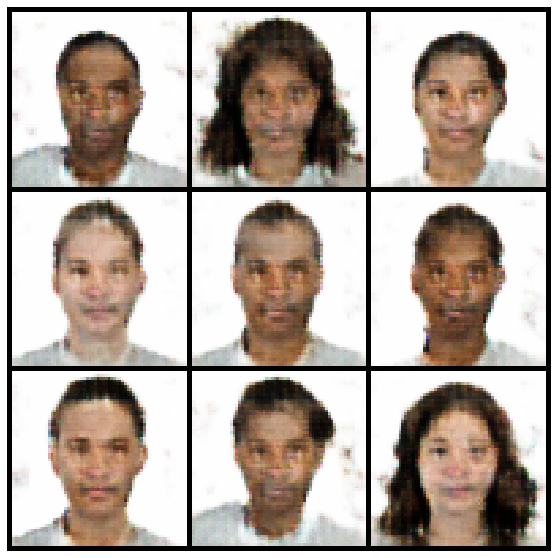

In [15]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### Real Images vs. Fake Images

Finally, let us look at real images and fake images side by side.

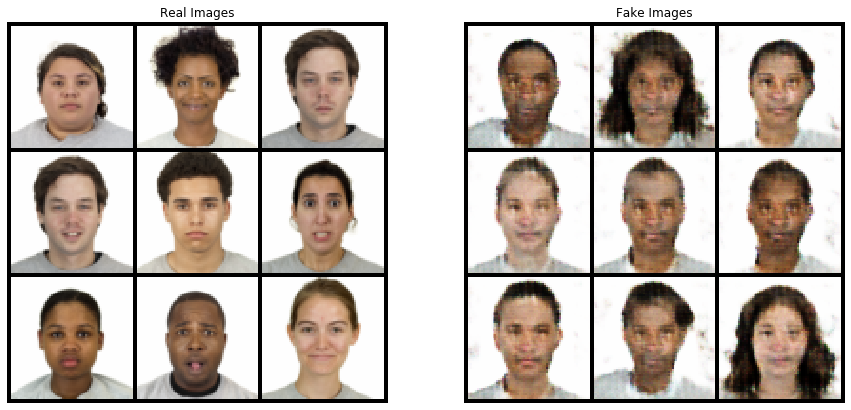

In [16]:
# Retrieve a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Trace the real images
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), nrow=int(batch_size**.5), padding=2, normalize=True).cpu(),(1,2,0)))
#plt.show()

# Trace the false images of the last epoch
#plt.figure(figsize=(10,10))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [17]:
fin = time.time()
print((fin-debut)//60, 'min')

10.0 min


# Where to go next


We have reached the end of our journey, but there are several places you can go from here. You could:

- Train longer to see how good the results are
- Modify this model to take a different data set and possibly modify the image size and architecture of the model.
- Take a look at some other cool GAN projects [here](https://github.com/nashory/gans-awesome-applications)
- Create GANs that generate [music](https://deepmind.com/blog/wavenet-generative-model-raw-audio/)